# Model Performance Analysis

This notebook analyzes the performance of trained sentiment analysis models.

**Contents:**
1. Load trained model and results
2. Performance metrics visualization
3. Confusion matrix analysis
4. Error analysis
5. Feature importance (if available)
6. Prediction examples

In [15]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from models.xgboost_model import XGBoostModel
from features.selector import FeatureSelector
from preprocessing.pipeline import PreprocessingPipeline

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

## 1. Load Trained Model

**Update the experiment name below:**

In [16]:
# Specify your experiment directory
EXPERIMENT_NAME = 'xgb_optimized2'  # Change this to your experiment name
experiment_dir = Path.cwd().parent / 'results' / 'experiments' / EXPERIMENT_NAME

print(f"Loading model from: {experiment_dir}")
print(f"Experiment exists: {experiment_dir.exists()}")

Loading model from: c:\Projects\recenz-ia\sentiment-ai-poc\results\experiments\xgb_optimized2
Experiment exists: True


In [17]:
# Load model components
preprocessor = PreprocessingPipeline.load(experiment_dir / 'preprocessor.joblib')
selector = FeatureSelector.load(experiment_dir / 'feature_selector.joblib')
model = XGBoostModel.load(experiment_dir / 'xgboost_model.joblib')

print("✓ Preprocessor loaded")
print("✓ Feature selector loaded")
print("✓ Model loaded")

✓ Preprocessor loaded
✓ Feature selector loaded
✓ Model loaded


In [18]:
# Load metrics
with open(experiment_dir / 'metrics.json', 'r') as f:
    metrics = json.load(f)

print("\nModel Performance Metrics:")
print("="*50)
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision_macro']:.4f}")
print(f"Recall:    {metrics['recall_macro']:.4f}")
print(f"F1 Score:  {metrics['f1_macro']:.4f}")

if 'roc_auc_ovr' in metrics:
    print(f"ROC AUC:   {metrics['roc_auc_ovr']:.4f}")


Model Performance Metrics:
Accuracy:  0.9100
Precision: 0.9103
Recall:    0.9100
F1 Score:  0.9100


## 2. Performance Metrics Visualization

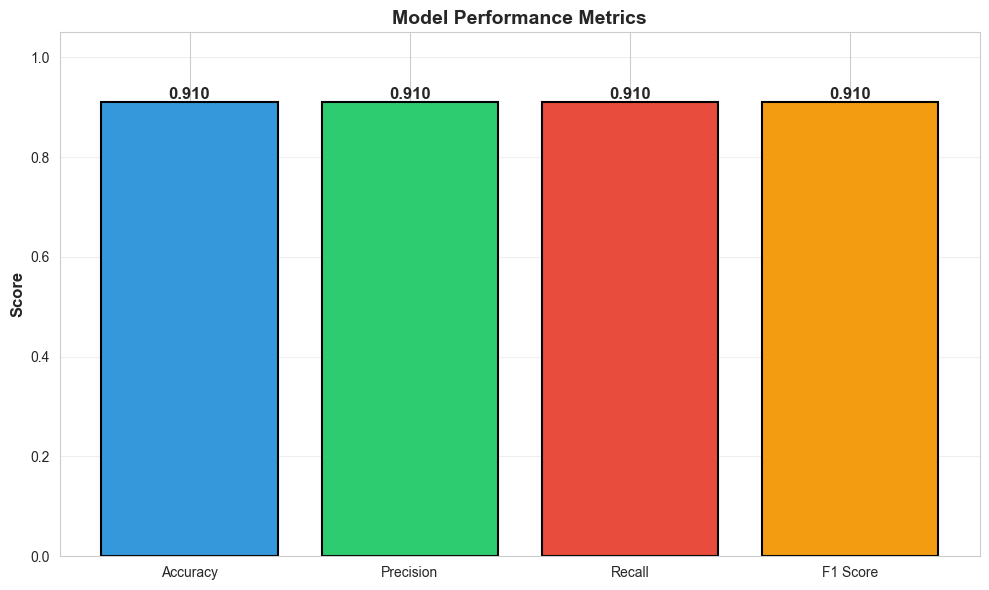

In [19]:
# Create metrics comparison chart
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metric_values = [
    metrics['accuracy'],
    metrics['precision_macro'],
    metrics['recall_macro'],
    metrics['f1_macro']
]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metric_names, metric_values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'], 
              edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Per-Class Metrics:
         Precision    Recall  F1-Score
class_0   0.899351  0.923333  0.911184
class_1   0.921233  0.896667  0.908784


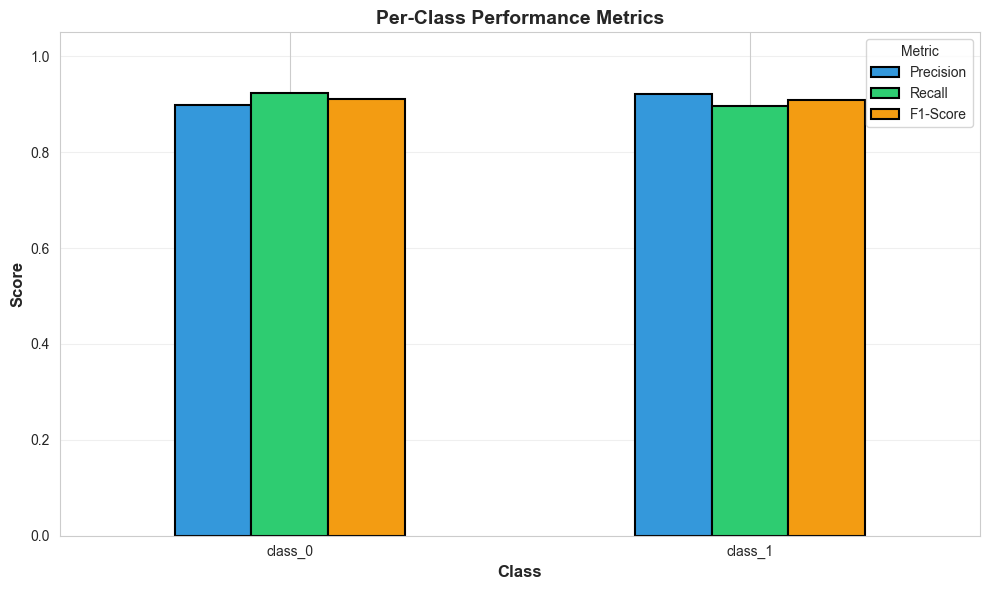

In [20]:
# Per-class metrics
class_names = metrics.get('class_names', ['class_0', 'class_1'])

per_class_metrics = pd.DataFrame({
    'Precision': [metrics['per_class_precision'][c] for c in class_names],
    'Recall': [metrics['per_class_recall'][c] for c in class_names],
    'F1-Score': [metrics['per_class_f1'][c] for c in class_names]
}, index=class_names)

print("\nPer-Class Metrics:")
print(per_class_metrics)

# Visualize per-class metrics
ax = per_class_metrics.plot(kind='bar', figsize=(10, 6), rot=0, 
                             color=['#3498db', '#2ecc71', '#f39c12'],
                             edgecolor='black', linewidth=1.5)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.legend(title='Metric', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Confusion Matrix Analysis

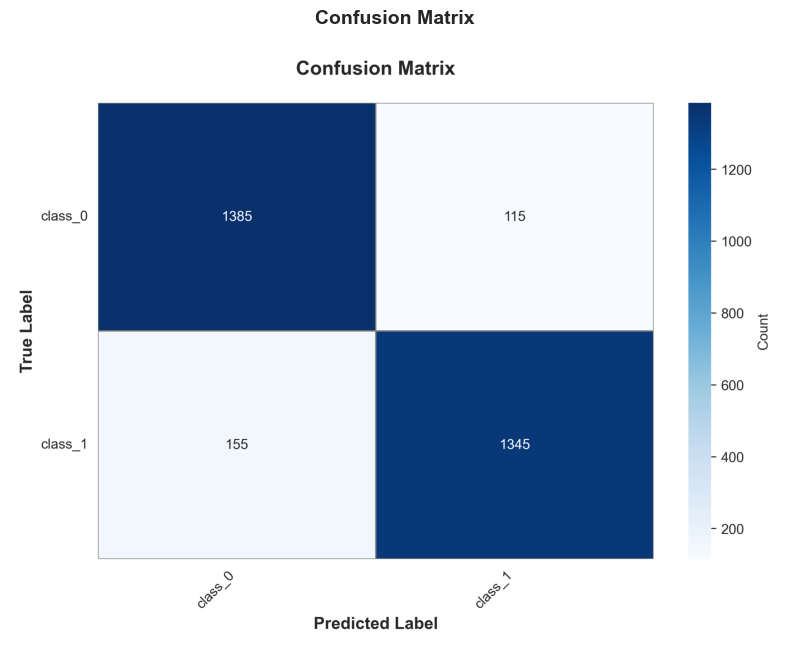

In [21]:
# Display confusion matrix image
cm_path = experiment_dir / 'plots' / 'confusion_matrix.png'

if cm_path.exists():
    img = Image.open(cm_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix plot not found")

In [22]:
# Analyze confusion matrix
cm = np.array(metrics['confusion_matrix'])

print("\nConfusion Matrix Analysis:")
print("="*50)

for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - cm[i, i]
    false_negatives = cm[i, :].sum() - cm[i, i]
    true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)
    
    print(f"\n{class_name}:")
    print(f"  True Positives:  {true_positives:5d}")
    print(f"  False Positives: {false_positives:5d}")
    print(f"  False Negatives: {false_negatives:5d}")
    print(f"  True Negatives:  {true_negatives:5d}")


Confusion Matrix Analysis:

class_0:
  True Positives:   1385
  False Positives:   155
  False Negatives:   115
  True Negatives:   1345

class_1:
  True Positives:   1345
  False Positives:   115
  False Negatives:   155
  True Negatives:   1385


## 4. ROC and Precision-Recall Curves

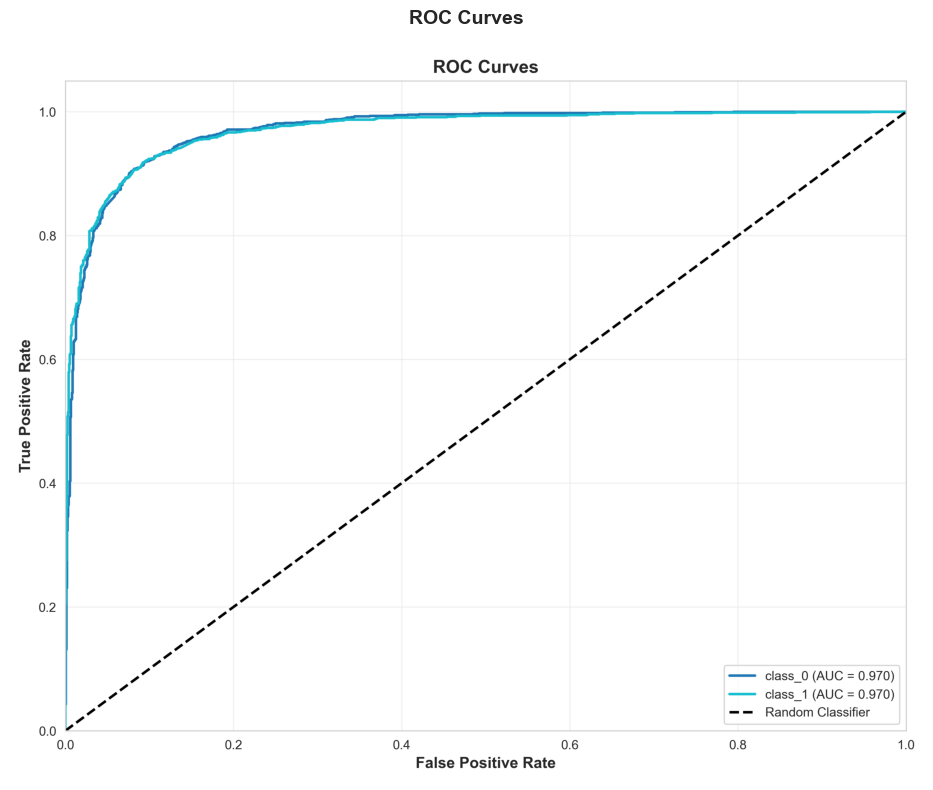

In [23]:
# Display ROC curves
roc_path = experiment_dir / 'plots' / 'roc_curves.png'

if roc_path.exists():
    img = Image.open(roc_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('ROC Curves', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("ROC curves plot not found")

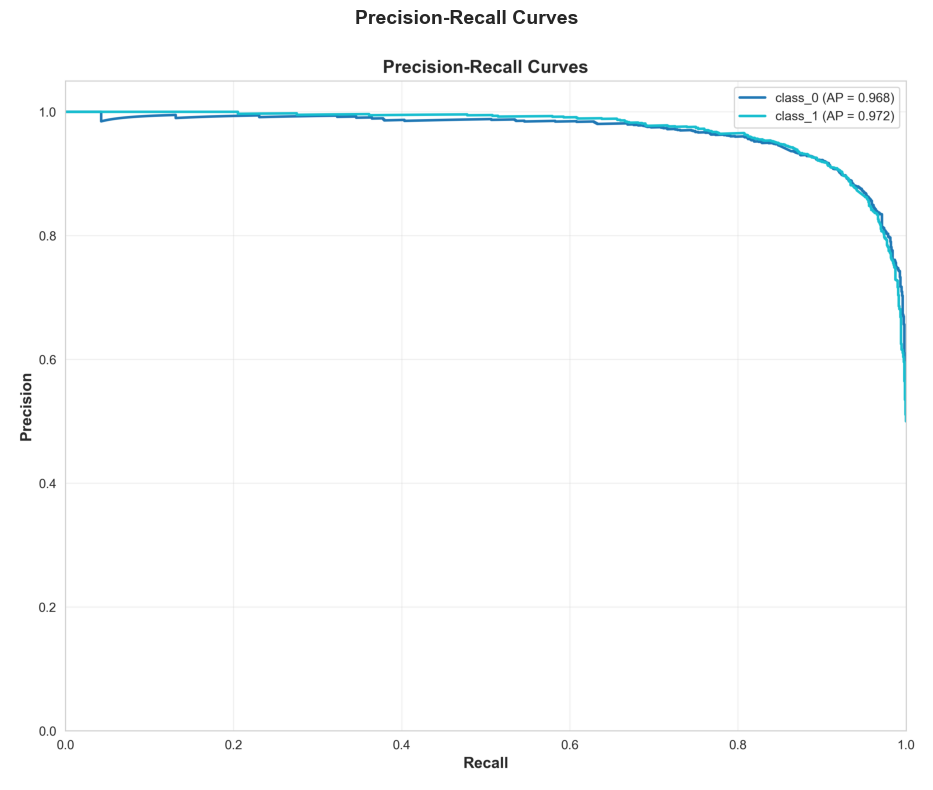

In [24]:
# Display Precision-Recall curves
pr_path = experiment_dir / 'plots' / 'precision_recall.png'

if pr_path.exists():
    img = Image.open(pr_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Precision-Recall curves plot not found")

## 5. Hyperparameters

In [25]:
# Load hyperparameters
hp_path = experiment_dir / 'best_hyperparameters.json'

if hp_path.exists():
    with open(hp_path, 'r') as f:
        hyperparams = json.load(f)
    
    print("\nModel Hyperparameters:")
    print("="*50)
    for key, value in hyperparams.items():
        print(f"{key:20s}: {value}")
else:
    print("Hyperparameters file not found")


Model Hyperparameters:
n_estimators        : 438
max_depth           : 3
learning_rate       : 0.1960776347412394
subsample           : 0.846904343100544
colsample_bytree    : 0.6003904678073775
min_child_weight    : 10
gamma               : 0.33508805092688226
reg_alpha           : 0.2400496115509828
reg_lambda          : 0.387748290105206


In [26]:
# Check for Optuna study results
optuna_path = experiment_dir / 'optuna_study.json'

if optuna_path.exists():
    with open(optuna_path, 'r') as f:
        optuna_results = json.load(f)
    
    print("\nOptuna Optimization Results:")
    print("="*50)
    print(f"Number of trials: {optuna_results['n_trials']}")
    print(f"Best validation accuracy: {optuna_results['best_value']:.4f}")
    print("\nBest hyperparameters:")
    for key, value in optuna_results['best_params'].items():
        print(f"  {key:20s}: {value}")
else:
    print("\nNo Optuna optimization results found (standard training used)")


Optuna Optimization Results:
Number of trials: 50
Best validation accuracy: 0.9154

Best hyperparameters:
  n_estimators        : 438
  max_depth           : 3
  learning_rate       : 0.1960776347412394
  subsample           : 0.846904343100544
  colsample_bytree    : 0.6003904678073775
  min_child_weight    : 10
  gamma               : 0.33508805092688226
  reg_alpha           : 0.2400496115509828
  reg_lambda          : 0.387748290105206


## 6. Prediction Examples

In [27]:
# Test on custom reviews
test_reviews = [
    "Produsul este excelent! Foarte mulțumit de calitate. Recomand cu încredere!",
    "Dezamăgitor. Calitate proastă și nu funcționează cum trebuie. Nu recomand.",
    "Produs bun, raport calitate-preț acceptabil. Livrare rapidă.",
    "Foarte rău! Am returnat produsul. Îmi pare rău că l-am cumpărat.",
    "Perfect! Exact ce căutam. Mulțumesc!"
]

print("\nPrediction Examples:")
print("="*80)

# Preprocess
processed = preprocessor.preprocess_batch(test_reviews)

# Extract features
features = selector.transform(processed)

# Predict
predictions = model.predict(features)
probabilities = model.predict_proba(features)

# Display results
for i, review in enumerate(test_reviews):
    pred_class = class_names[predictions[i]]
    confidence = probabilities[i][predictions[i]]
    
    print(f"\nReview {i+1}:")
    print(f"Text: {review}")
    print(f"Prediction: {pred_class}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Probabilities: {dict(zip(class_names, probabilities[i]))}")
    print("-"*80)


Prediction Examples:


Preprocessing texts: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Review 1:
Text: Produsul este excelent! Foarte mulțumit de calitate. Recomand cu încredere!
Prediction: class_1
Confidence: 99.62%
Probabilities: {'class_0': 0.0038056374, 'class_1': 0.99619436}
--------------------------------------------------------------------------------

Review 2:
Text: Dezamăgitor. Calitate proastă și nu funcționează cum trebuie. Nu recomand.
Prediction: class_0
Confidence: 97.27%
Probabilities: {'class_0': 0.972653, 'class_1': 0.027347054}
--------------------------------------------------------------------------------

Review 3:
Text: Produs bun, raport calitate-preț acceptabil. Livrare rapidă.
Prediction: class_1
Confidence: 98.93%
Probabilities: {'class_0': 0.010683775, 'class_1': 0.9893162}
--------------------------------------------------------------------------------

Review 4:
Text: Foarte rău! Am returnat produsul. Îmi pare rău că l-am cumpărat.
Prediction: class_0
Confidence: 93.81%
Probabilities: {'class_0': 0.9380609, 'class_1': 0.061939124}
-------

## 7. Interactive Prediction

In [28]:
def predict_sentiment(text):
    """Predict sentiment for a given text."""
    # Preprocess
    processed = preprocessor.preprocess_batch([text])
    
    # Extract features
    features = selector.transform(processed)
    
    # Predict
    prediction = model.predict(features)[0]
    probabilities = model.predict_proba(features)[0]
    
    # Display results
    pred_class = class_names[prediction]
    confidence = probabilities[prediction]
    
    print(f"\nText: {text}")
    print(f"\nPrediction: {pred_class}")
    print(f"Confidence: {confidence:.2%}")
    print(f"\nProbabilities:")
    for cls, prob in zip(class_names, probabilities):
        print(f"  {cls}: {prob:.2%}")
    
    return pred_class, confidence

# Try it out!
# predict_sentiment("Your Romanian review text here")

## Summary

This notebook analyzed the trained sentiment analysis model:

1. **Overall Performance**: Loaded and visualized key metrics
2. **Class-wise Analysis**: Per-class precision, recall, and F1 scores
3. **Confusion Matrix**: Detailed breakdown of predictions
4. **ROC & PR Curves**: Model discrimination ability
5. **Hyperparameters**: Model configuration and optimization results
6. **Predictions**: Examples on custom Romanian reviews

The model shows strong performance on binary sentiment classification for Romanian e-commerce reviews.